In [132]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time, sleep
import threading
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
import time

%matplotlib inline

In [133]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Functions on the backgroun

In [134]:
# Function to track GPU memory usage
def track_gpu_utilization(interval=1):
    memory_usage = []
    timestamps = []
    
    # Define a helper function to gather GPU memory usage
    def record_utilization():
        while tracking:
            mem = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
            memory_usage.append(mem)
            timestamps.append(time() - start_time)
            sleep(interval)  # Wait before recording again

    # Start tracking in a separate thread
    tracking = True
    start_time = time()
    tracking_thread = threading.Thread(target=record_utilization)
    tracking_thread.start()
    
    return memory_usage, timestamps, lambda: tracking_thread.join()
# Visualization function
def plot_gpu_utilization(memory_usage, timestamps):
    clear_output(wait=True)
    plt.plot(timestamps, memory_usage, label='GPU Memory Usage (GB)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Memory Usage (GB)')
    plt.title('GPU Memory Utilization Over Time')
    plt.legend()
    plt.show()

def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing


def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")
print_gpu_utilization()  # Print memory before starting the optimization loop

# Visualization function 
def visualize_glacier(x, Z, Z_bed, z_ELA, b, Time):
    Z_list = Z.cpu().tolist()  # Convert to list
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    b_list = b.cpu().tolist()  # Convert to list
    clear_output(wait=True)  # Clear the previous output in the notebook
    
    plt.figure(2, figsize=(7, 5), dpi=200)
    plt.subplot(2, 2, 1)
    plt.plot([xi / 1000 for xi in x_list], Z_list, 'b', linewidth=2) 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA, z_ELA], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier après ' + str(int(Time)) + ' années')

    plt.subplot(2, 2, 2)
    plt.plot([min(grad_b * (zi - z_ELA), b_max) for zi in Z_list], Z_list, '--k', linewidth=2)
    plt.plot([min(b_list), b_max + 0.3], [z_ELA, z_ELA], 'g')
    plt.plot([0, 0], [min(Z_bed_list), max(Z_bed_list)], 'k', linewidth=1)
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.title('Fonction bilan de masse') 
    plt.xlabel('Bilan de masse, m/a')  

    plt.subplot(2, 2, 3, aspect=20.0)
    plt.plot([xi / 1000 for xi in x_list], b_list, 'b', linewidth=2)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [0, 0], 'k', linewidth=1)
    plt.title('Bilan de masse effectif')
    plt.xlabel('Distance, km') 
    plt.ylabel('Bilan de masse, m/a') 

    plt.show()
    
# Visualization function 
def visualize_evolution(x, Z_list, Z_bed, z_ELA,observed_thk):
    Z_lists=[Z_list[i].cpu().tolist()  for i  in range (len(Z_list))]
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    z_ELA_list=z_ELA.cpu().tolist()
    Z_observed=(Z_bed+observed_thk).cpu().tolist()

    clear_output(wait=False)  # Clear the previous output in the notebook
    plt.figure(figsize=(7, 4), dpi=200)
    plt.plot([xi / 1000 for xi in x_list], Z_lists[0], 'b', linewidth=1,linestyle='dashed',label='Evolution in time') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[1], 'b', linewidth=1,linestyle='dashed') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[2], 'b', linewidth=1,linestyle='dashed') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[3], 'b', linewidth=1,label='Last thickness') 
    plt.plot([xi / 1000 for xi in x_list], Z_observed, 'r', linewidth=1,label='Observed thickness') 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1,label='ELA')
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA_list, z_ELA_list], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier evolution')
    plt.legend()

    plt.show()
def compute_slope(Z, dx):
    # Compute the slope (gradient of surface) using finite difference
    slope = torch.diff(Z) / dx
    return slope


GPU memory occupied: 706 MB.


In [135]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n db/dELA:",torch.mean(grad))
    return grad
def print_hook_h(grad):
    print("\n dH/db:",torch.mean(grad))
    return grad
def sqrt_hook(grad):
    if torch.abs(torch.mean(grad))>1:
        print(grad**0.5)
        return grad**0.5
def reduce_hook(grad):
    return grad*0.9

### Simulation

In [136]:
# Physics
b_max = 0.3  # maximum ice balance m/yr
grad_b = 0.001  # gradient of ice balance as a function of elevation. yr^-1

z_ELA = 900  # equilibrium line altitude
Lx = 3e5  # model length, m
ttot = 1500  # total time
rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
kD = fd * rhog**3  # lump all constants for diffusivity together
epsilon = 1e-12 # Epsilon to avoid division by zero



# Numerics
nx = 201  # number of cells
dx = Lx / (nx - 1)  # number of cells 
dtmax = 1      # initial dt, will be changed within loop, yr
dt    = dtmax  # initial dt, will be changed within loop, yr
x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
nout = 100  # frequency of plotting

# Initialization
Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography
H_initial= torch.zeros(nx, device=device) #torch.load('initial_thickness.pt', weights_only=True).to(device)
H = H_initial.clone()
Time = 0.0  # initialize time
nplot = 0  # counter for plotting

Z = Z_bed + H  # ice surface

it = 0


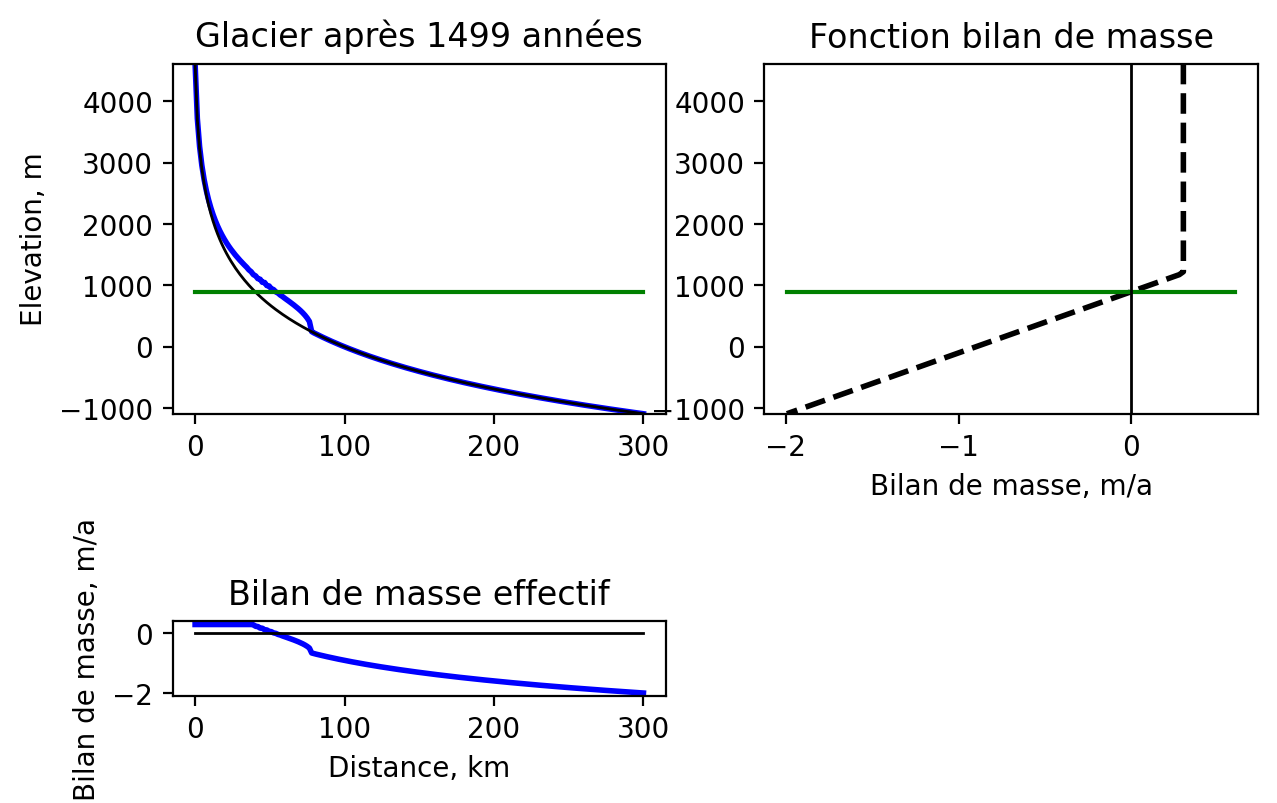

Elapsed time is : 3.125948667526245 s


In [137]:
# Initialize lists to store data for training
data = []

# Time loop
start = time.time()

while Time < ttot:

    # compute dHdt due to diffusion
    H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
    D = kD * H_av**5 * (torch.diff(Z) / dx)**2  # diffusivity (nx-1)
    qx = -D * torch.diff(Z) / dx  # ice flux

    dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow

    # update time step as function of D
    max_D = torch.max(D).item()
    dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

    # update thickness of ice (iceflow)
    H[1:-1] += dt * dHdt  # update ice thickness from flow

    # update ice thickness (mass balance)
    b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
    H[1:-1] += dt * b[1:-1]

    H[H < 0] = 0  # set any negative thickness to 0

    # Boundary conditions
    H[0] = 0
    H[-1] = 0

    Z = Z_bed + H  # update ice surface
    Time += dt  # update time

    it += 1


    # Call visualization function
    if it % nout == 0:
 
        visualize_glacier(x, Z, Z_bed, z_ELA, b, Time)
end = time.time()
print(f"Elapsed time is : {end - start} s")

In [138]:
# Sav e the observations.
torch.save(H,'observed_thk.pt')


In [139]:
# Function to perform forward simulation of glacier thickness with differentiable operations

def forward_simulation(H_initial,b_max, grad_b,z_ELA, nx=201, Lx=1e5, ttot=3e3, dtmax=1, device=device,display_time=False):
    start= time.time()
    # helper for visualization
    H_history=[]
    flag=0
    threshold=int(ttot/4)
    # Physics constants
    n=3
    rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
    fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
    kD = fd * rhog**n  # lump all constants for diffusivity together
    Lx = 3e5  # model length, m
    dx = Lx / (nx - 1)  # cell size
    epsilon = 1e-12

    # Numerics
    nx = 201  # number of cells
    dx = Lx / (nx - 1)  # number of cells 
    dtmax = 1      # initial dt, will be changed within loop, yr
    dt    = dtmax  # initial dt, will be changed within loop, yr
    Time = 0

    # Initialization
    x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
    Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography (avoid log(0))
    H = H_initial.clone()  # initial ice thickness
    Z = Z_bed + H  # ice surface

    while Time < ttot:
        # compute dHdt due to diffusion
        H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
        D = kD * H_av**5 * (torch.diff(Z) / dx)**(n-1)  # diffusivity (nx-1)
        qx = -D * torch.diff(Z) / dx  # ice flux
        # Compute velocity safely
        dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow
        
        # update time step as function of D
        max_D = torch.max(D).item()
        dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

        # update thickness of ice (iceflow)
        H[1:-1] += dt * dHdt  # update ice thickness from flow
    
        # update ice thickness (mass balance)
        b = torch.minimum(grad_b * (Z - z_ELA), torch.tensor(b_max, device=device)) 
        b.retain_grad() 
        b.register_hook(reduce_hook)
        
        H[1:-1] += dt * b[1:-1]
        H.retain_grad()
        H.register_hook(reduce_hook)
        H[H < 0] = 0  # set any negative thickness to 0
    
        # Boundary conditions
        H[0] = 0
        H[-1] = 0
    
        Z = Z_bed + H  # update ice surface
        Time += dt  # update time
        #update the history of H
        if int(Time)%threshold == 0 and flag<4:
            flag+=1
            H_history.append(Z)
    if display_time:
        end = time.time()
        print(f"Elapsed time is : {end - start} s")    

    return H,H_history

In [140]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()
# Initial guesses for inversion problem
b_max = 0.3
grad_b = 0.001
z_ELA = torch.tensor(1200.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('observed_thk.pt', weights_only=True).to(device) # Ensure it's on the right device

# Define initial and final learning rates
initial_lr = 7
final_lr = 2
n_iterations = 60

# Optimizer setup
optimizer = torch.optim.Adam([z_ELA], lr=initial_lr)


# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]
ELA_evolution=[]

for i in range(n_iterations):
    # Update the learning rate
    lr = initial_lr - (i / (n_iterations - 1)) * (initial_lr - final_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated, Z_history = forward_simulation(H_initial,b_max, grad_b, z_ELA,ttot=ttot,display_time=False)
    
    # Compute data missfit
    loss = torch.mean((H_simulated - observed_thk)**2)
     
    
    # Backpropagate loss and update parameters
    loss.backward()
    
    # Clip gradients to the range [-1, 1]
    # torch.nn.utils.clip_grad_value_(z_ELA, clip_value=10.0)
    # Store the gradients and ela 
    total_gradients_history.append(z_ELA.grad.item())
    ELA_evolution.append(z_ELA.item())

    optimizer.step()

    
    # Store loss components for plotting later
    total_loss_history.append(loss.item())
        # Print loss, gradients and current parameters every 50 iterations 
    if (i + 1) % 20 == 0:
        # visualize_evolution(x, Z_history, Z_bed, z_ELA,observed_thk)
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {loss:.3f} ")
        print(f"Gradient of ELA : {z_ELA.grad.item()} ELA is {z_ELA} m")

print_gpu_utilization()  # Print memory after the loop
print_peak_gpu_memory()  # Print the peak memory 


Iteration 20/60, Loss: 2257.813 
Gradient of ELA : 2.53678297996521 ELA is 1080.5054931640625 m

Iteration 40/60, Loss: 1142.314 
Gradient of ELA : 10735682.0 ELA is 1011.6911010742188 m

Iteration 60/60, Loss: 727.056 
Gradient of ELA : 648320253952.0 ELA is 982.2420043945312 m
GPU memory occupied: 823 MB.
Peak GPU memory used: 19.35 MB.


In [ ]:
# Stop tracking and plot results when done
# stop_tracking()  # Wait for tracking thread to finish
# plot_gpu_utilization(memory_usage, timestamps)

In [ ]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Loss', color='b', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# After the optimization loop
plot_loss_components(total_loss_history)


### Use hooks to access the intermediate gradients

https://www.youtube.com/watch?v=syLFCVYua6Q&ab_channel=ElliotWaite